# <font color=blue>Immigration and Employment</font>

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import sqlite3
import glob
import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

## Cleaning the data

### Data from Integrated Public Use Microdata Series (IPUMS)

We downloaded data from 2007 to 2016 in five different files (each with two years) as the files are too large. We selected the following variables: age (AGE), sex (SEX), migration status (MIGRATE1), citizenship (CITIZEN), hispanic status (HISPANIC), state (STATEFIP), county (COUNTYFIPS), and weight of population (PERWT)

To clean the five files we used a loop as the variables are the same for all files:

In [2]:
files=["2007", "2009", "2011", "2013", "2015"]
for filename in files:    
    df = pd.read_csv("IPUMS"+ filename + '.csv', 
                     usecols=["YEAR", "STATEFIP", "COUNTYFIPS", "PERWT", "SEX", "AGE", "HISPAN", "CITIZEN", "MIGRATE1"])
    #select persons that are not US citizens and that 1 year ago were living abroad
    #select only US states, do not consider Puerto Rico, Alaska, Virgin Islands, Hawaii
    #do not consider counties whose code is zero
    #do not consider persons that did not respond about their race (HISPAN=9)
    df2 = df[(df.CITIZEN == 3) & (df.MIGRATE1 == 4) & (df.HISPAN != 9) & (df.STATEFIP != 2) & (df.STATEFIP != 3)
                        & (df.STATEFIP != 7) & (df.STATEFIP != 14) & (df.STATEFIP != 15) & (df.STATEFIP != 43) 
                        & (df.STATEFIP != 52) & (df.COUNTYFIPS > 0)]
    #rename variables so it is easier to calculate proportions
    #the code for persons that are hispanic is set to zero
    df2["HISPAN2"] = 0
    #the code for persons that are not hispanic (0) is set to one
    df2.loc[df2["HISPAN"] == 0,  "HISPAN2"] = 1
    #the code for males is set to zero and the code for females (2) is set to one
    df2["SEX2"] = 0
    df2.loc[df2["SEX"] == 2,  "SEX2"] = 1
    #group by county, state, and year
    #calculate the mean of age, sex, and hispanic people (proportion), the number of migrants, and the sum of the weights (perwt)
    df3 = df2.groupby(["COUNTYFIPS", "STATEFIP", "YEAR"]).agg({'AGE': 'mean', 'SEX2': 'mean', 'HISPAN2': 'mean', 
                                                               'MIGRATE1': 'count', 'PERWT': 'sum'}).reset_index()
    #convert COUNTYFIPS to string
    df3.COUNTYFIPS = df3.COUNTYFIPS.astype(str)
    #convert STATEFIP to string
    df3.STATEFIP = df3.STATEFIP.astype(str)
    #add leading zeros to COUNTYFIPS so that the total number of digits is three
    df3['COUNTYFIPS'] = df3['COUNTYFIPS'].apply(lambda x: x.zfill(3))
    #add leading zeros to STATEFIP so that the total number of digits is two
    df3['STATEFIP'] = df3['STATEFIP'].apply(lambda x: x.zfill(2))
    #combine STATEFIP and COUNTYFIPS in one colummn
    df3["ID"] = df3["STATEFIP"] + df3["COUNTYFIPS"]
    #change the index to the new variable ID
    df3.set_index('ID', inplace=True)
    #save the data in separate files
    df3.to_csv('IPUMSclean' + filename + '.csv')

FileNotFoundError: File b'IPUMS2007.csv' does not exist

We also used a loop to merge the five files into one single file that contains data from IPUMS (2007-2016)

In [3]:
df_allyears = pd.DataFrame()
df_allyears = pd.read_csv("IPUMSclean2007.csv", index_col=None, header=0)
df_allyears["Year_merge"] = 2007

for num in (2009,2011,2013,2015):
    filename = "IPUMSclean" + str(num) + ".csv"
    df_oneyear = pd.read_csv(filename, index_col=None, header=0)
    df_oneyear["Year_merge"] = num
    frames = [df_allyears, df_oneyear]
    df_allyears = pd.concat(frames)
df_allyears
df_allyears.to_csv('IPUMS_allyears.csv')

This file is already cleaned and ready to be merged with the dataset of the American Community Survey.

### Data from American Community Survey (ACS)

From the ACS, we downloaded the available data from 2007 to 2016 in one CSV file for each year (10 in total). From each file we selected the following variables: FIPS county number (ID), total population estimate (population), Labor force participation rate (Labor Part), employment rate (Employment), and unemployment rate (Unemployment)

In order to clean each CSV, we ran a loop through all ACS csv files where we selected the variables that we needed and created a clean csv file for each one.

In [4]:
#We created a for loop to clean each of the American Community Survey csv files.
files=["2007", "2008", "2009", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016"]
for filename in files:    
    ACS = pd.read_csv("ACS_"+filename+ ".csv", 
 #select the columns we need
                      usecols=["GEO.id2", "HC01_EST_VC01", "HC02_EST_VC01", "HC03_EST_VC01", "HC04_EST_VC01"], 
  #skip the 1 row - the headeer
                      skiprows=[1])
 #rename variables   
    ACS = ACS.rename(columns={'GEO.id2': 'ID', 'HC01_EST_VC01': 'Population', 'HC02_EST_VC01': 'Labor Part.',
                              'HC03_EST_VC01': 'Employment', 'HC04_EST_VC01': 'Unemployment'})
#setting ID as the index
    ACS.set_index('ID', inplace=True)                  
#Generating a clean csv for each year    
    ACS.to_csv('ACSclean' + filename + '.csv')

Once we had the clean csv files for each year we created a for loop to make one single csv file that has all the years

In [5]:
df_allyears = pd.DataFrame()
df_allyears = pd.read_csv("ACSclean2007.csv", index_col=None, header=0)
df_allyears["YEAR"] = 2007

#create a loop to concat all the csv files into one that has all the years
for num in range (2008,2017):
    filename = "ACSclean" + str(num) + ".csv"
    df_oneyear = pd.read_csv(filename, index_col=None, header=0)
    df_oneyear["YEAR"] = num
    frames = [df_allyears, df_oneyear]
    df_allyears = pd.concat(frames)
df_allyears
df_allyears.to_csv('ACS_allyears.csv')

## Merging datasets from IPUMS and ACS

To merge the dataset we used the column ID as index and the code for "outer" since we are just keeping the values that are common to both datasets.

In [6]:
df_ACS = pd.read_csv("ACS_allyears.csv")
df_IPUMS = pd.read_csv("IPUMS_allyears.csv")

In [7]:
df_merged = df_ACS.merge(df_IPUMS, on = ['ID','YEAR'], how='inner')
df_merged.head()

,Unnamed: 0_x,ID,Population,Labor Part.,Employment,Unemployment,YEAR,Unnamed: 0_y,COUNTYFIPS,STATEFIP,AGE,SEX2,HISPAN2,MIGRATE1,PERWT,Year_merge
0,0,1003,135873,61.0,58.9,3.2,2007,20,3,1,22.000000,0.400000,0.900000,10,2378,2007
1,7,1073,520153,62.6,58.0,7.2,2007,348,73,1,30.666667,0.666667,1.000000,3,899,2007
2,9,1081,104436,62.6,58.9,4.8,2007,363,81,1,37.857143,0.285714,0.571429,7,479,2007
3,13,1097,310354,59.7,55.2,7.1,2007,432,97,1,31.500000,0.100000,0.400000,10,1416,2007
4,17,1117,138992,70.1,66.9,4.4,2007,497,117,1,26.666667,1.000000,1.000000,3,426,2007


We eliminate columns that we will not use.

In [8]:
df_merged.drop(df_merged.columns[[0, 7, 8, 
    9, 15]], axis=1, inplace=True)
df_merged.head()

,ID,Population,Labor Part.,Employment,Unemployment,YEAR,AGE,SEX2,HISPAN2,MIGRATE1,PERWT
0,1003,135873,61.0,58.9,3.2,2007,22.000000,0.400000,0.900000,10,2378
1,1073,520153,62.6,58.0,7.2,2007,30.666667,0.666667,1.000000,3,899
2,1081,104436,62.6,58.9,4.8,2007,37.857143,0.285714,0.571429,7,479
3,1097,310354,59.7,55.2,7.1,2007,31.500000,0.100000,0.400000,10,1416
4,1117,138992,70.1,66.9,4.4,2007,26.666667,1.000000,1.000000,3,426


In [9]:
df_merged.to_csv('ACSIPUMS_merged.csv')

## Plotting the variables

In order to see the relationships between unemployment/employment and the number of immigrants in each county we plotted the variables. We used MIGRATE1 and also created a new variable (Total_Weighted) which accounts for the weight of the immigrants. We also tried plotting the log of Total_weighted variable.

In [10]:
df_merged = pd.read_csv("ACSIPUMS_merged.csv", index_col=None, header=0)

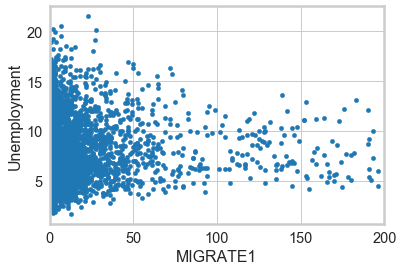

In [11]:
#Scatter plot unemployment rate and number of immigrants per county
df_merged.plot(kind = "scatter", x = "MIGRATE1", y = "Unemployment", xlim = [0,200])

In [ ]:
#Scatter plot employment rate and number of immigrants per county
df_merged.plot(kind = "scatter", x = "MIGRATE1", y = "Employment", xlim = [0,200])

In [ ]:
#create a new variable "Total_Weighted" - the multiplocation of the number of immigrants by the weight
#first we convert the variables into flots to be able to multiply them together
df_merged[['MIGRATE1', 'PERWT']] = df_merged[['MIGRATE1', 'PERWT']].astype(float)
#now we can multiply together
df_merged['Total_weighted'] = df_merged['MIGRATE1']*df_merged['PERWT']
df_merged.head()

In [ ]:
#Scatter plot Unemployment & Total_weighted
df_merged.plot(kind = "scatter", x = "Total_weighted", y = "Unemployment")

In [ ]:
#Scatter plot Employment & Total_weighted
df_merged.plot(kind = "scatter", x = "Total_weighted", y = "Employment")

In [ ]:
#Scatter plot Log Total weighted & Unemployment
df_merged['log_Total_weighted'] = np.log(df_merged['Total_weighted'])
df_merged.plot(kind = "scatter", x = "log_Total_weighted", y = "Unemployment")

In [ ]:
#Scatter plot Log Total weighted & Employment 
df_merged['log_Total_weighted'] = np.log(df_merged['Total_weighted'])
df_merged.plot(kind = "scatter", x = "log_Total_weighted", y = "Employment")#, xlim=[0, 1])

# Mapping the variables

We mapped the number of immigrants by county in the United States!

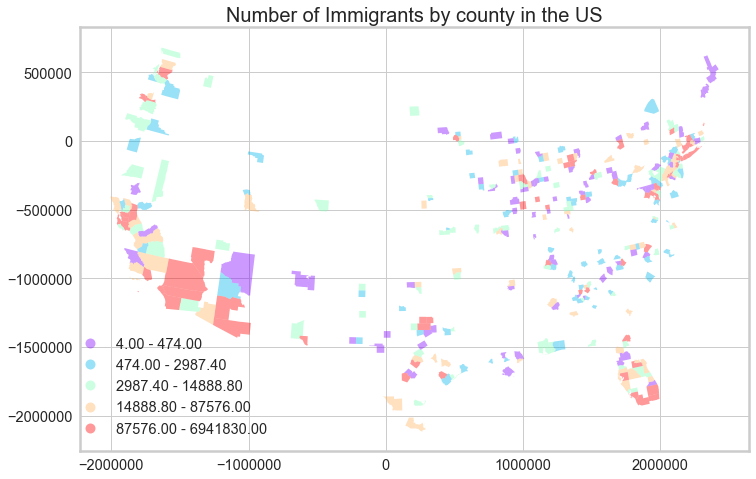

In [7]:
import geopandas as gpd
#import the file that has the coordinates for US counties
geo = gpd.read_file("cb_2016_us_county_500k.shp")
#create a new variable called ID that combines state and county fips so we can merge this file with the ACS/IPUMS file
geo["ID"] = geo["STATEFP"] + geo["COUNTYFP"]
#convert ID to an integer as this same variable is an integer in the ACS/IPUMS file
geo['ID'] = geo['ID'].astype(int)
#read the file of ACS/IPUMS
IPUMS_ACS = pd.read_csv('ACSIPUMS_merged.csv')
#merge both files (ACS/IPUMS and geo/coordinates)
IPUMS_ACS_GEO = geo.merge(IPUMS_ACS, on = ['ID'], how='right')
#select the year 2016 so that the map is based on only one year and not ten
IPUMS_ACS_GEO = IPUMS_ACS_GEO[(IPUMS_ACS_GEO.YEAR == 2016)]
IPUMS_ACS_GEO2 = IPUMS_ACS_GEO.to_crs(epsg=2163)
#map the number of immigrants and apply other formats to the figure
IPUMS_ACS_GEO3 = IPUMS_ACS_GEO2.plot(column = "Total_weighted", scheme = "quantiles", k = 5, cmap = "rainbow", legend = True,
                 alpha = 0.4, linewidth = 0.5, figsize = (12, 8))
#change the location of the legend to prevent the map from being covered
leg = IPUMS_ACS_GEO3.get_legend()
leg.set_bbox_to_anchor((0., 0., 0.3, 0.3))
#add a title to the map
IPUMS_ACS_GEO3.set_title("Number of Immigrants in US counties", fontsize = 20)

Now, we mapped the unemployment rate by county in the United States

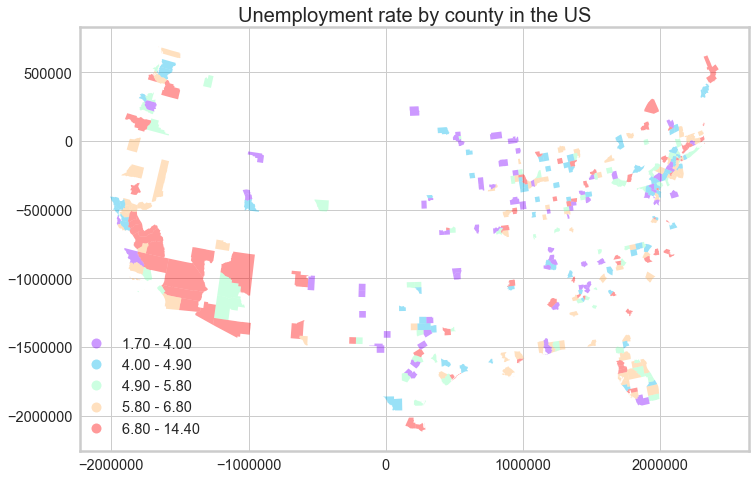

In [16]:
#apply the same code, but for the unemployment rate
IPUMS_ACS_GEO3 = IPUMS_ACS_GEO2.plot(column = "Unemployment", scheme = "quantiles", k = 5, cmap = "rainbow", legend = True,
                 alpha = 0.4, linewidth = 0.5, figsize = (12, 8))
leg = IPUMS_ACS_GEO3.get_legend()
leg.set_bbox_to_anchor((0., 0., 0.2, 0.3))
IPUMS_ACS_GEO3.set_title("Unemployment rate by county in the US", fontsize = 20)

# Running regressions!! 

We ran a weighted OLS regression to determine the impact of migration on employment.

In [9]:
df_formula= pd.read_csv ("ACSIPUMS_merged.csv")
result = smf.wls(formula= "Unemployment ~ MIGRATE1 + HISPAN2 + AGE + SEX2 ", data= df_formula, weights = df_formula["PERWT"]).fit()
print (result.summary())

                            WLS Regression Results                            
Dep. Variable:           Unemployment   R-squared:                       0.022
Model:                            WLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     18.46
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           5.13e-15
Time:                        17:01:36   Log-Likelihood:                -10048.
No. Observations:                3359   AIC:                         2.011e+04
Df Residuals:                    3354   BIC:                         2.014e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2953      0.373     19.541      0.0

We created a lag to better identify the causality between past migration and employment.

In [10]:
df_formula['LAGMIGRATE']= df_formula['MIGRATE1'].shift(1)
df_formula.shift(-1).head(5)

,Unnamed: 0,ID,Population,Labor Part.,Employment,Unemployment,YEAR,AGE,SEX2,HISPAN2,MIGRATE1,PERWT,LAGMIGRATE
0,1.0,1073.0,520153.0,62.6,58.0,7.2,2007.0,30.666667,0.666667,1.000000,3.0,899.0,10.0
1,2.0,1081.0,104436.0,62.6,58.9,4.8,2007.0,37.857143,0.285714,0.571429,7.0,479.0,3.0
2,3.0,1097.0,310354.0,59.7,55.2,7.1,2007.0,31.500000,0.100000,0.400000,10.0,1416.0,7.0
3,4.0,1117.0,138992.0,70.1,66.9,4.4,2007.0,26.666667,1.000000,1.000000,3.0,426.0,10.0
4,5.0,4005.0,99127.0,70.2,67.1,4.4,2007.0,27.000000,1.000000,0.000000,2.0,45.0,3.0


In [12]:
result = smf.wls(formula= "Unemployment ~ LAGMIGRATE + MIGRATE1 + HISPAN2 + AGE + SEX2", data= df_formula, weights = df_formula["PERWT"]).fit()
print (result.summary())

                            WLS Regression Results                            
Dep. Variable:           Unemployment   R-squared:                       0.022
Model:                            WLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     15.20
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           8.42e-15
Time:                        17:01:57   Log-Likelihood:                -10044.
No. Observations:                3358   AIC:                         2.010e+04
Df Residuals:                    3352   BIC:                         2.014e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2459      0.375     19.320      0.0

In [13]:
result = smf.wls(formula= "Employment ~ LAGMIGRATE + MIGRATE1 + HISPAN2 + AGE + SEX2", data= df_formula, weights = df_formula["PERWT"]).fit()
print (result.summary())

                            WLS Regression Results                            
Dep. Variable:             Employment   R-squared:                       0.114
Model:                            WLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     86.52
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           8.95e-86
Time:                        17:02:10   Log-Likelihood:                -11745.
No. Observations:                3358   AIC:                         2.350e+04
Df Residuals:                    3352   BIC:                         2.354e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.2440      0.622     99.998      0.0